In [1]:
import shelly.shelly as shelly

shelly.download_mains_data()
shelly.download_solar_data()

95.2kiB [00:01, 84.5kiB/s]



Download completed. File saved as /workspace/data/shelly/em_data.main.csv



95.0kiB [00:01, 81.8kiB/s]


Download completed. File saved as /workspace/data/shelly/em_data.solar.csv


In [2]:
import pandas as pd

main_df = pd.read_csv(
    "/workspace/data/shelly/em_data.main.csv",
    sep=",",
    names=[
        "timestamp_utc",
        "main_consumed_energy(Wh)",
        "main_returned_energy(Wh)",
        "main_voltage_min(V)",
        "main_voltage_max(V)",
    ],
    dtype={
        "main_consumed_energy(Wh)": "Float64",
        "main_returned_energy(Wh)": "Float64",
        "main_voltage_min(V)": "Float64",
        "main_voltage_max(V)": "Float64",
    },
    parse_dates=["timestamp_utc"],
    header=0,
)
solar_df = pd.read_csv(
    "/workspace/data/shelly/em_data.solar.csv",
    sep=",",
    names=[
        "timestamp_utc",
        "solar_produced_energy(Wh)",
        "solar_returned_energy(Wh)",
        "solar_voltage_min(V)",
        "solar_voltage_max(V)",
    ],
    dtype={
        "solar_produced_energy(Wh)": "Float64",
        "solar_returned_energy(Wh)": "Float64",
        "solar_voltage_min(V)": "Float64",
        "solar_voltage_max(V)": "Float64",
    },
    parse_dates=["timestamp_utc"],
    header=0,
)

In [3]:
main_df.index = pd.to_datetime(main_df["timestamp_utc"]).dt.tz_localize("UTC")
main_df.drop(
    columns=["timestamp_utc", "main_voltage_min(V)", "main_voltage_max(V)"],
    inplace=True,
)
main_df.rename(columns={"main_consumed_energy(Wh)": "main_consumed_Wh"}, inplace=True)
main_df.rename(columns={"main_returned_energy(Wh)": "main_returned_Wh"}, inplace=True)
main_df.head()

,main_consumed_Wh,main_returned_Wh
timestamp_utc,,
2024-04-20 00:00:00+00:00,10.37,0.0
2024-04-20 00:01:00+00:00,9.37,0.0
2024-04-20 00:02:00+00:00,9.65,0.0
2024-04-20 00:03:00+00:00,9.51,0.0
2024-04-20 00:04:00+00:00,9.66,0.0


In [4]:
solar_df.index = pd.to_datetime(solar_df["timestamp_utc"]).dt.tz_localize("UTC")
solar_df.drop(
    columns=[
        "timestamp_utc",
        "solar_returned_energy(Wh)",
        "solar_voltage_min(V)",
        "solar_voltage_max(V)",
    ],
    inplace=True,
)
solar_df.rename(columns={"solar_produced_energy(Wh)": "solar_Wh"}, inplace=True)
solar_df.head()

,solar_Wh
timestamp_utc,
2024-04-20 00:00:00+00:00,0.08
2024-04-20 00:01:00+00:00,0.08
2024-04-20 00:02:00+00:00,0.08
2024-04-20 00:03:00+00:00,0.08
2024-04-20 00:04:00+00:00,0.08


In [5]:
shelly_df = pd.concat([main_df, solar_df], axis=1)
shelly_df = shelly_df.resample("15min").sum()
shelly_df["main_Wh"] = shelly_df["main_consumed_Wh"] - shelly_df["main_returned_Wh"]
shelly_df["consumed_Wh"] = shelly_df["main_Wh"] + shelly_df["solar_Wh"]
shelly_df = shelly_df[["main_Wh", "solar_Wh", "consumed_Wh"]]
shelly_df = shelly_df / 1000
shelly_df.rename(
    columns={
        "main_Wh": "main_kWh",
        "solar_Wh": "solar_kWh",
        "consumed_Wh": "consumed_kWh",
    },
    inplace=True,
)
shelly_df["main_kWh"] = shelly_df["main_kWh"].round(6)
shelly_df["solar_kWh"] = shelly_df["solar_kWh"].round(6)
shelly_df["consumed_kWh"] = shelly_df["consumed_kWh"].round(6)
shelly_df.to_csv("/workspace/data/shelly_consumption_history.csv")
shelly_df.tail()

,main_kWh,solar_kWh,consumed_kWh
timestamp_utc,,,
2024-04-20 07:45:00+00:00,0.03709,0.06707,0.10416
2024-04-20 08:00:00+00:00,0.05723,0.06355,0.12078
2024-04-20 08:15:00+00:00,0.03697,0.07171,0.10868
2024-04-20 08:30:00+00:00,-0.00985,0.08746,0.07761
2024-04-20 08:45:00+00:00,-0.00492,0.01495,0.01003


In [6]:
import providers.repsol as repsol

repsol_prices_df = repsol.get_latest_prices()

In [7]:
costs_df = shelly_df.join(repsol_prices_df, how="inner")
costs_df["bought_€"] = (costs_df["€/kWh"] * costs_df["main_kWh"]).clip(lower=0)
costs_df["lost_€"] = -(costs_df["€/kWh"] * costs_df["main_kWh"]).clip(upper=0)
costs_df["solar_production_€"] = costs_df["€/kWh"] * costs_df["solar_kWh"]
costs_df["solar_consumtion_€"] = costs_df["solar_production_€"] - costs_df["lost_€"]
costs_df["consumed_€"] = costs_df["€/kWh"] * costs_df["consumed_kWh"]
costs_df[
    [
        "consumed_€",
        "bought_€",
        "solar_consumtion_€",
        "solar_production_€",
        "lost_€",
    ]
].resample("1h").sum()

,consumed_€,bought_€,solar_consumtion_€,solar_production_€,lost_€
2024-04-19 00:00:00+00:00,0.012953,0.012848,0.000105,0.000105,0.0
2024-04-19 01:00:00+00:00,0.008003,0.007868,0.000135,0.000135,0.0
2024-04-19 02:00:00+00:00,0.00967,0.009533,0.000137,0.000137,0.0
2024-04-19 03:00:00+00:00,0.006152,0.006009,0.000143,0.000143,0.0
2024-04-19 04:00:00+00:00,0.007364,0.007246,0.000118,0.000118,0.0
2024-04-19 05:00:00+00:00,0.009504,0.009314,0.00019,0.00019,0.0
2024-04-19 06:00:00+00:00,0.010135,0.007746,0.002389,0.002389,0.0
2024-04-19 07:00:00+00:00,0.028484,0.014065,0.014418,0.015167,0.000749
2024-04-19 08:00:00+00:00,0.025821,0.003898,0.021924,0.032605,0.010681
2024-04-19 09:00:00+00:00,0.015108,0.004591,0.010517,0.021142,0.010625


In [8]:
costs_df[
    [
        "consumed_€",
        "bought_€",
        "solar_consumtion_€",
        "solar_production_€",
        "lost_€",
    ]
].resample("1D").sum()

,consumed_€,bought_€,solar_consumtion_€,solar_production_€,lost_€
2024-04-19 00:00:00+00:00,0.460108,0.321001,0.139107,0.172664,0.033557
2024-04-20 00:00:00+00:00,0.079954,0.069923,0.010031,0.010371,0.00034


In [9]:
current_month_consumption_history_df = pd.read_csv(
    "/workspace/data/current_month_consumption_history.csv",
    sep=",",
    header=0,
    index_col=0,
    names=["timestamp_utc", "Consumption (kWh)", "Injection (kWh)"],
    dtype={"Consumption (kWh)": "Float64", "Injection (kWh)": "Float64"},
    parse_dates=["timestamp_utc"],
)
shelly_consumption_history_df = pd.read_csv(
    "/workspace/data/shelly_consumption_history.csv",
    sep=",",
    header=0,
    index_col=0,
    names=["timestamp_utc", "Grid (kWh)", "Solar (kWh)", "Consumed (kWh)"],
    dtype={
        "Grid (kWh)": "Float64",
        "Solar (kWh)": "Float64",
        "Consumed (kWh)": "Float64",
    },
    parse_dates=["timestamp_utc"],
)

compare_df = pd.merge(
    current_month_consumption_history_df,
    shelly_consumption_history_df,
    left_index=True,
    right_index=True,
    how="inner",
)

In [10]:
compare_df = compare_df.resample("30min").sum()
compare_df

,Consumption (kWh),Injection (kWh),Grid (kWh),Solar (kWh),Consumed (kWh)
timestamp_utc,,,,,
2024-04-16 07:30:00+00:00,0.0,0.042,-0.0098,0.0903,0.0805
2024-04-16 08:00:00+00:00,0.0,0.136,-0.1424,0.2685,0.1261
2024-04-16 08:30:00+00:00,0.0,0.22,-0.2252,0.3465,0.1213
2024-04-16 09:00:00+00:00,0.0,0.13,-0.1302,0.4134,0.2832
2024-04-16 09:30:00+00:00,0.0,0.334,-0.3404,0.4708,0.1304
...,...,...,...,...,...
2024-04-19 03:30:00+00:00,0.097,0.0,0.09699,0.0024,0.09939
2024-04-19 04:00:00+00:00,0.133,0.0,0.13715,0.0024,0.13955
2024-04-19 04:30:00+00:00,0.156,0.0,0.15659,0.0024,0.15899


<Axes: xlabel='timestamp_utc'>

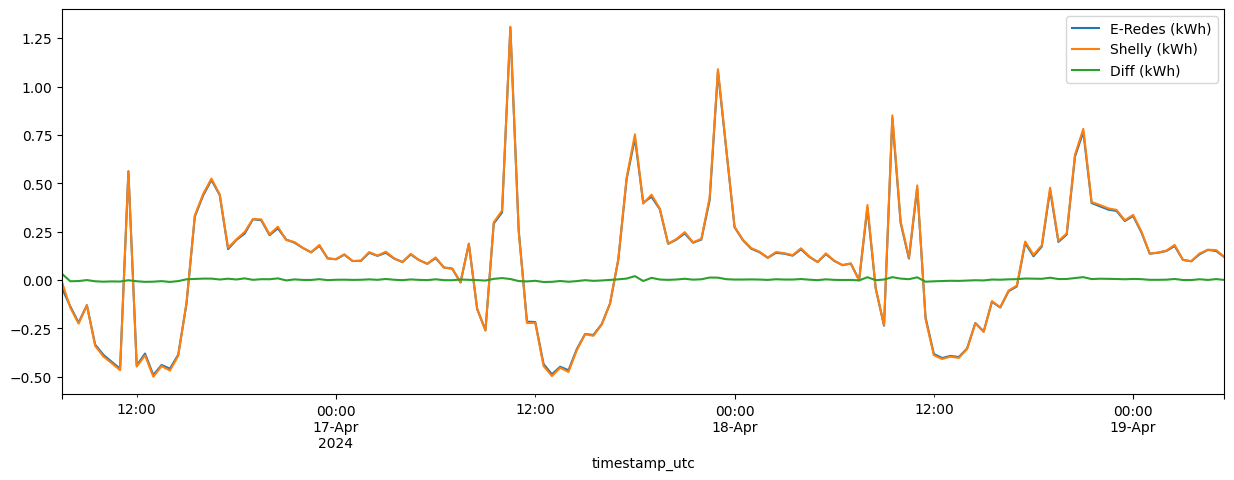

In [11]:
compare_df.loc[:, "E-Redes (kWh)"] = (
    compare_df.loc[:, "Consumption (kWh)"] - compare_df.loc[:, "Injection (kWh)"]
)
compare_df.loc[:, "Shelly (kWh)"] = compare_df.loc[:, "Grid (kWh)"]
compare_df.loc[:, "Diff (kWh)"] = (
    compare_df.loc[:, "Grid (kWh)"]
    - compare_df.loc[:, "Consumption (kWh)"]
    + compare_df.loc[:, "Injection (kWh)"]
)
# compare_df = compare_df[compare_df.index >= "2024-04-19"]
compare_df[
    [
        "E-Redes (kWh)",
        "Shelly (kWh)",
        "Diff (kWh)",
    ]
].plot.line(figsize=(15, 5))

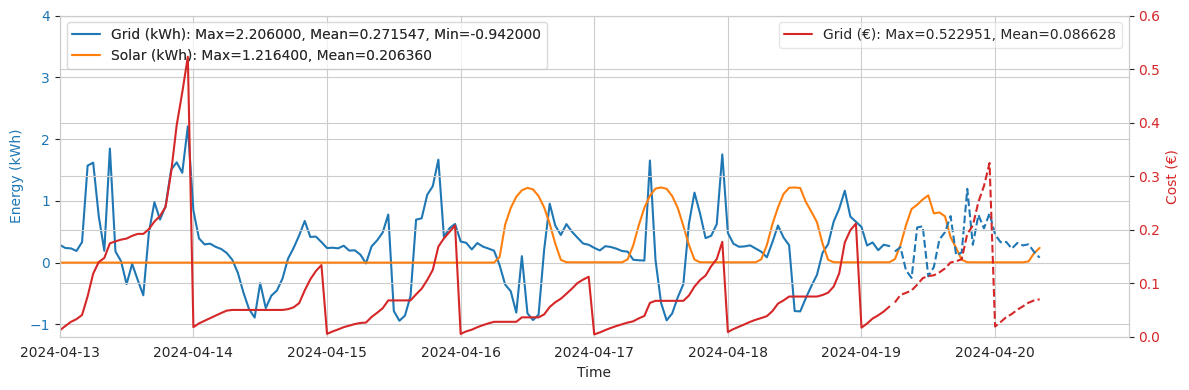

In [18]:
from datetime import datetime, timedelta

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import providers.repsol as repsol


current_month_consumption_history_df = pd.read_csv(
    "/workspace/data/current_month_consumption_history.csv",
    sep=",",
    header=0,
    index_col=0,
    names=["timestamp_utc", "Consumption (kWh)", "Injection (kWh)"],
    dtype={"Consumption (kWh)": "Float64", "Injection (kWh)": "Float64"},
    parse_dates=["timestamp_utc"],
)
shelly_consumption_history_df = pd.read_csv(
    "/workspace/data/shelly_consumption_history.csv",
    sep=",",
    header=0,
    index_col=0,
    names=["timestamp_utc", "Grid (kWh)", "Solar (kWh)", "Consumed (kWh)"],
    dtype={
        "Grid (kWh)": "Float64",
        "Solar (kWh)": "Float64",
        "Consumed (kWh)": "Float64",
    },
    parse_dates=["timestamp_utc"],
)
e_redes_df = pd.DataFrame()
e_redes_df.loc[:, "Grid (kWh)"] = (
    +current_month_consumption_history_df.loc[:, "Consumption (kWh)"]
    - current_month_consumption_history_df.loc[:, "Injection (kWh)"]
)
combine_df = e_redes_df.combine_first(shelly_consumption_history_df)[["Grid (kWh)"]]
energy_consumtion_history_df = combine_df.join(
    shelly_consumption_history_df[["Solar (kWh)"]], how="left"
)
# Get the current date and time
now = datetime.now()

# Calculate the date and time for days ago
days_ago = now - timedelta(days=7)
days_ago = pd.Timestamp(days_ago).normalize().tz_localize("UTC")

# Calculate the end of today
end_of_today = (
    pd.Timestamp(now).normalize().tz_localize("UTC")
    + pd.Timedelta(days=1)
    - pd.Timedelta(seconds=1)
)

# Filter the DataFrame to only include data since two days ago
energy_consumtion_history_df_last_days = energy_consumtion_history_df[
    energy_consumtion_history_df.index >= days_ago
]

repsol_prices_df = repsol.get_prices()
repsol_prices_df.index = repsol_prices_df["starting_datetime"]
repsol_prices_df.drop(columns=["starting_datetime"], inplace=True)

energy_consumtion_history_df_last_days = energy_consumtion_history_df_last_days.join(
    repsol_prices_df, how="left"
)

energy_consumtion_history_df_last_days.loc[:, "Grid (€)"] = (
    energy_consumtion_history_df_last_days["€/kWh"]
    * energy_consumtion_history_df_last_days["Grid (kWh)"]
).clip(lower=0)

# Assuming that energy_consumtion_history_df_last_days is your DataFrame
df = energy_consumtion_history_df_last_days.resample("1h").sum()

# Calculate the cumulative sum of the 'Grid (€)' column for each day
df["Grid (€)"] = df.groupby(df.index.day)["Grid (€)"].cumsum()

# Calculate the date and time for two days ago
latest_real_timestamp = current_month_consumption_history_df.index.max()

# Set the style of seaborn
sns.set_style("whitegrid")

res: tuple[Figure, plt.Axes] = plt.subplots(figsize=(12, 4))
fig, ax1 = res

ax1.set_xlabel("Time")
ax1.set_ylabel("Energy (kWh)", color="tab:blue")
ax1.plot(
    df[df.index <= latest_real_timestamp].index,
    df[df.index <= latest_real_timestamp]["Grid (kWh)"],
    color="tab:blue",
    label="Grid (kWh)",
)
ax1.plot(
    df.index,
    df["Solar (kWh)"],
    color="tab:orange",
    label="Solar (kWh)",
)
ax1.plot(
    df[df.index > latest_real_timestamp].index,
    df[df.index > latest_real_timestamp]["Grid (kWh)"],
    color="tab:blue",
    linestyle="dashed",
)
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(-1.2, 4)  # Set limits for the first y-axis

# Calculate the max, mean, and min for Grid (kWh)
max_grid = np.max(df["Grid (kWh)"])
mean_grid = np.mean(df["Grid (kWh)"])
min_grid = np.min(df["Grid (kWh)"])

# Calculate the max, mean, and min for Solar (kWh)
max_solar = np.max(df["Solar (kWh)"])
mean_solar = np.mean(df["Solar (kWh)"])

# Add legends
legend1 = ax1.legend(
    [
        f"Grid (kWh): Max={max_grid:.6f}, Mean={mean_grid:.6f}, Min={min_grid:.6f}",
        f"Solar (kWh): Max={max_solar:.6f}, Mean={mean_solar:.6f}",
    ],
    loc="upper left",
    framealpha=0.5,
)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Cost (€)", color=color)
# Plot with different styles based on the date
ax2.plot(
    df[df.index <= latest_real_timestamp].index,
    df[df.index <= latest_real_timestamp]["Grid (€)"],
    color=color,
    label="Grid (€)",
)
ax2.plot(
    df[df.index > latest_real_timestamp].index,
    df[df.index > latest_real_timestamp]["Grid (€)"],
    color=color,
    linestyle="dashed",
)
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylim(0, 0.6)  # Set limits for the second y-axis

# Calculate the max, mean, and min for Grid (€)
max_grid_euro = np.max(df["Grid (€)"])
mean_grid_euro = np.mean(df["Grid (€)"])

# Add legend
ax2.legend(
    [f"Grid (€): Max={max_grid_euro:.6f}, Mean={mean_grid_euro:.6f}"],
    loc="upper right",
    framealpha=0.5,
)

# Add the legend manually to the current Axes.
ax1.add_artist(legend1)

# Set x-axis limits
ax1.set_xlim([days_ago, end_of_today])

fig.tight_layout()
plt.show()